In [1]:
using POMDPs
using POMDPTools
using QuickPOMDPs
using MCTS
using POMDPSimulators
using Distributions
using LinearAlgebra
using D3Trees
using Random
using Plots

# Parameters

In [26]:
# Dimensions
max_progress = 10
max_power = 50
max_h2o = 50
max_o2 = 50
max_food = 50

# Uncertainties
p_mission_regression = 0.05
p_power_fail = 0.02
p_water_loss = 0.02
p_food_loss = 0.02
p_no_mission_progress = 0.05

# Resource consumption
consumed_power = -2 # generated
consumed_h2o = 1
consumed_o2 = 1
consumed_food = 1

1

In [28]:
# Define all possible states and actions (with constraints)
# [progress, power, h2o, o2, food]
indexed = LinearIndices((max_progress, max_power, max_h2o, max_o2, max_food))
states = 1:indexed[max_progress, max_power, max_h2o, max_o2, max_food]

basic_actions = [
      CartesianIndex(1, -3, 0, 0, 0), # make mission progress
      CartesianIndex(0, -1, 8, 0, 0), # make water 
      CartesianIndex(0, -1, -1, 7, 0), # make oxygen
      CartesianIndex(0, -1, -1, -1, 6), # make food
      CartesianIndex(0, 0, 0, 0, 0) # do nothing
] 
consumed = CartesianIndex(0, consumed_power, consumed_h2o, consumed_o2, consumed_food)
actions = [action - consumed for action in basic_actions]

5-element Vector{CartesianIndex{5}}:
 CartesianIndex(1, -1, -1, -1, -1)
 CartesianIndex(0, 1, 7, -1, -1)
 CartesianIndex(0, 1, -2, 6, -1)
 CartesianIndex(0, 1, -2, -2, 5)
 CartesianIndex(0, 2, -1, -1, -1)

In [29]:
# Determine if action is out of bounds
# Associated consequences are reflected in transition/reward functions
state_maxes = [max_progress, max_power, max_h2o, max_o2, max_food]
function inbounds(state, action)
    for i in 1:length(state)
        if ((state[i] + action[i]) < 1 || (state[i] + action[i]) > state_maxes[i])
            return false
        end
    end
    return true
end

function clamp_state(state)
    for i in 1:length(state)
        state[i] = clamp(state[i], 1, state_maxes[i])
    end
    return state
end

function cartesian2linear(svec)
    return indexed[CartesianIndex(Tuple(svec))]
end

function linear2cartesian(s)
    return CartesianIndices((max_progress, max_power, max_h2o, max_o2, max_food))[s]
end


linear2cartesian (generic function with 1 method)

In [43]:
# Is terminal?
function isterminal(s)
    svec = linear2cartesian(s)
    end_state = svec[1] == max_progress # If reached a goal state
    failed = all([any([(svec[i] + a[i]) < 1 for i in 1:length(svec)]) for a in actions]) # If all actions result in negative out of bounds (failed mission)
    return end_state || failed 
end

# Random action (must be valid) (only call when valid action exists)
function random_action(s)
    svec = linear2cartesian(s)
    a = rand(actions)
    if !inbounds(svec, a)
        a = random_action(s)
    end
    return a
end

# Transition function
function transition(s, a)
    p_nominal = 1 - p_no_mission_progress - p_water_loss - p_power_fail - p_mission_regression 
    p = [p_no_mission_progress, p_water_loss, p_power_fail, p_mission_regression, p_nominal]

    svec = collect(Tuple(linear2cartesian(s)))
    a = collect(Tuple(a))
    if !inbounds(svec, a)
        a = collect(Tuple(last(actions))) # Try "do nothing"
        if inbounds(svec, a) # If "do nothing" works
            spvec = svec + a
        else # If "do nothing" is not possible
            #spvec = svec + collect(Tuple(random_action(s))) # We choose a random action that is valid (see random_action()) assuming that isterminal() would catch failed states beforehand
            spvec = svec
        end
        sp = cartesian2linear(clamp_state(spvec))
        return SparseCat([sp,], [1,])
    else
        spvec_no_mission_progress = svec + collect(Tuple(last(actions)))

        spvec_water_loss = svec + a
        spvec_water_loss[3] = round(0.5 * spvec_water_loss[3]) # lose all water

        spvec_power_fail = svec + a
        spvec_power_fail[2] = round(0.5 * spvec_power_fail[2]) # lose all energy

        spvec_mission_regression = svec + a
        spvec_mission_regression[1] = spvec_mission_regression[1] - 1 # mission setback

        spvec_nominal = svec + a

        spvec = [spvec_no_mission_progress, spvec_water_loss, spvec_power_fail, spvec_mission_regression, spvec_nominal]
    end
    
    sp = []
    for i in 1:length(p)
        push!(sp, cartesian2linear(clamp_state(spvec[i])))
    end
    return SparseCat(sp, p)
    
end

# Reward function
function reward(s, a)
    svec = linear2cartesian(s)
    spvec = svec + a
    if spvec[1] == max_progress
        r = 1e6
    elseif !inbounds(svec, a) # If invalid action
        r = -1e12
    else
        r = 0
    end
    return r
end

reward (generic function with 1 method)

In [48]:
function generate_mdp(initialstate, states=states, actions=actions, discount=0.5, isterminal=isterminal, transition=transition, reward=reward)
    return QuickMDP(
        states = states,
        actions = actions,
        initialstate = initialstate,
        discount = discount,
        isterminal = isterminal,
        transition = transition,
        reward = reward
    )
end

generate_mdp (generic function with 7 methods)

# MCTS Simulation

In [49]:
function simulate_mcts(initialstate, iter, rollout_iter, depth, replan_interval)

    history = []
    s = initialstate
    push!(history, s)
    policy = rollout_policy(s, rollout_iter, depth)

    for i in 1:iter

        if isterminal(s)
            break
        end

        if i % replan_interval == 0 # Replan
            policy = rollout_policy(s, rollout_iter, depth )
        end

        a = action(policy, s)
        T = transition(s, a)
        s = rand(T) # CHECK IF THIS WORKS
        push!(history, s)

    end

    return history

end

function rollout_policy(state, rollout_iter, depth)
    mdp = generate_mdp(state)
    solver = MCTSSolver(n_iterations=rollout_iter, depth=depth, exploration_constant=1.0, enable_tree_vis=true)
    policy = solve(solver, mdp)
    return policy
end

rollout_policy (generic function with 1 method)

In [53]:
initialstate = indexed[1, 10, 10, 10, 10]

11479591

In [54]:
history_var = simulate_mcts(initialstate, 100, 10000, 50, 2)

50-element Vector{Any}:
 11479591
 10208051
  8932571
  7831581
 14030591
 12755111
 11483621
 10382631
  9111141
 15310151
        ⋮
 28057426
 26781917
 25506408
 24230928
 22959438
 21687948
 27886958
 26611449
 25335940

In [58]:
history_var = [linear2cartesian(s) for s in history_var]

50-element Vector{CartesianIndex{5}}:
 CartesianIndex(1, 10, 10, 10, 10)
 CartesianIndex(1, 6, 17, 9, 9)
 CartesianIndex(1, 8, 16, 8, 8)
 CartesianIndex(1, 9, 14, 14, 7)
 CartesianIndex(1, 10, 12, 12, 12)
 CartesianIndex(1, 12, 11, 11, 11)
 CartesianIndex(1, 13, 18, 10, 10)
 CartesianIndex(1, 14, 16, 16, 9)
 CartesianIndex(1, 15, 23, 15, 8)
 CartesianIndex(1, 16, 21, 13, 13)
 ⋮
 CartesianIndex(6, 43, 15, 23, 23)
 CartesianIndex(7, 42, 14, 22, 22)
 CartesianIndex(8, 41, 13, 21, 21)
 CartesianIndex(8, 43, 12, 20, 20)
 CartesianIndex(8, 44, 19, 19, 19)
 CartesianIndex(8, 45, 26, 18, 18)
 CartesianIndex(8, 46, 24, 16, 23)
 CartesianIndex(9, 45, 23, 15, 22)
 CartesianIndex(10, 44, 22, 14, 21)

In [59]:
history_progress = [s[1] / max_progress for s in history_var]
history_power = [s[2] / max_power for s in history_var]
history_h2o = [s[3] / max_h2o for s in history_var]
history_o2 = [s[4] / max_o2 for s in history_var]
history_food = [s[5] / max_food for s in history_var]

50-element Vector{Float64}:
 0.2
 0.18
 0.16
 0.14
 0.24
 0.22
 0.2
 0.18
 0.16
 0.26
 ⋮
 0.46
 0.44
 0.42
 0.4
 0.38
 0.36
 0.46
 0.44
 0.42

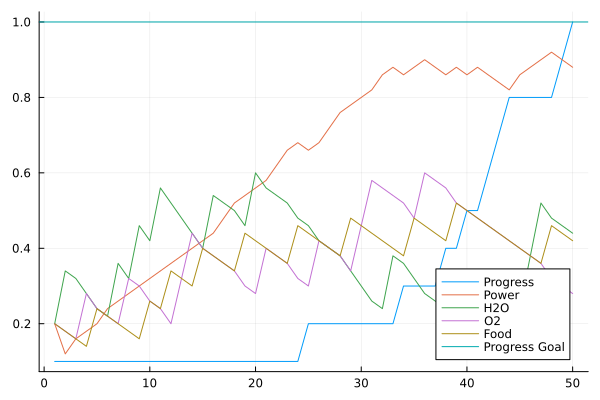

In [60]:
p1 = plot()
plot!(
    p1,
    1:length(history_var),
    [history_progress history_power history_h2o history_o2 history_food],
    label=["Progress" "Power" "H2O" "O2" "Food"]
)
hline!(p1, [1], label="Progress Goal")

# Random Simulation

In [13]:
function simulate_random(initialstate, iter)
    s = initialstate
    history = []
    push!(history, s)
    for _ in 1:iter
        if isterminal(s)
            break
        end
        a = random_action(s) # Choose valid action randomly
        T = transition(s, a)
        s = rand(T)
        push!(history, s)
    end
    return history
end

simulate_random (generic function with 1 method)

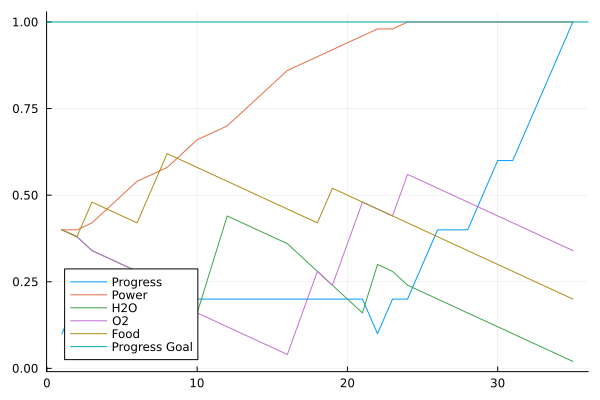

In [14]:
rand_history = simulate_random(initialstate, 100)
rand_history = [linear2cartesian(s) for s in rand_history]
rand_history_progress = [s[1] / max_progress for s in rand_history]
rand_history_power = [s[2] / max_power for s in rand_history]
rand_history_h2o = [s[3] / max_h2o for s in rand_history]
rand_history_o2 = [s[4] / max_o2 for s in rand_history]
rand_history_food = [s[5] / max_food for s in rand_history]
p2 = plot()
plot!(
    p2,
    1:length(rand_history),
    [rand_history_progress rand_history_power rand_history_h2o rand_history_o2 rand_history_food],
    label=["Progress" "Power" "H2O" "O2" "Food"]
)
hline!(p2, [1], label="Progress Goal")